In [1]:
import os, re, time, pickle, collections, importlib, datetime, torch, nltk, pandas as pd, numpy as np, random
from chardet import detect
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict, Counter
from wordebd import WORDEBD
from vocab import Vocab, Vectors
from munch import Munch
from cnnlstmseq import CNNLSTMseq
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from nltk.tokenize import word_tokenize
from model import MaskedNLLLoss, LSTMModel, GRUModel, DialogRNNModel, DialogueGCNModel, DialogueGCN_DailyModel
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
# Autoreload extensions (if you're using Jupyter Notebook or IPython)
%load_ext autoreload
%autoreload 2

In [2]:
key=False

In [3]:
SEED = 42

class CNNFeatureExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_size, filters, kernel_sizes, dropout):
        super(CNNFeatureExtractor, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList(
            [nn.Conv1d(in_channels=embedding_dim, out_channels=filters, kernel_size=K) for K in kernel_sizes])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * filters, output_size)
        self.feature_dim = output_size

    def init_pretrained_embeddings_from_numpy(self, pretrained_word_vectors):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        self.embedding.weight.requires_grad = False

    def forward(self, x, umask):
        if len(x.size()) == 2:  # Check if x has only 2 dimensions
            num_utt, num_words = x.size()
            batch = 1
        else:
            num_utt, batch, num_words = x.size()

        x = x.type(torch.LongTensor)
        x = x.view(-1, num_words)  # Flatten to (num_utt * batch, num_words)
        torch.manual_seed(SEED)
        emb = self.embedding(x)  # Embed (num_utt * batch, num_words) -> (num_utt * batch, num_words, embedding_dim)
        emb = emb.transpose(-2, -1).contiguous()  # (num_utt * batch, num_words, embedding_dim) -> (num_utt * batch, embedding_dim, num_words)

        convoluted = [F.relu(conv(emb)) for conv in self.convs]
        pooled = [F.max_pool1d(c, c.size(2)).squeeze(2) for c in convoluted]
        concated = torch.cat(pooled, 1)
        features = F.relu(self.fc(self.dropout(concated)))  # Apply dropout and fully connected layer
        features = features.view(num_utt, batch, -1)  # Reshape back to (num_utt, batch, feature_dim)

        mask = umask.unsqueeze(-1).type(torch.FloatTensor)  # (batch, num_utt) -> (batch, num_utt, 1)
        mask = mask.transpose(0, 1)  # (batch, num_utt, 1) -> (num_utt, batch, 1)
        mask = mask.repeat(1, 1, self.feature_dim)  # (num_utt, batch, 1) -> (num_utt, batch, feature_dim)
        features = features * mask  # Apply mask

        return features

In [4]:
def get_encoding_type(file):
    with open(file, 'rb') as f:
        rawdata = f.read()
    return detect(rawdata)['encoding']

def detect_misspelling(source):
    pass

def replace_spelling(source):
    return re.sub("Åf", "'", source)

In [5]:
def preprocess_text(data):
    '''
    Preprocess text data
    @param data: list of text examples
    @return preprocessed_data: list of preprocessed text examples
    '''
    preprocessed_data = []
    for example in data:
        # Convert to lowercase
        example = example.lower()
        # Remove punctuation
        example = re.sub(r'[^\w\s]', '', example)
        preprocessed_data.append(example)
    return preprocessed_data

def load_pretrained_glove():
    print("Loading GloVe...")
    glv_vector = {}
    f = open('embed/glove/glove.840B.300d.txt', encoding='utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float')
            glv_vector[word] = coefs
        except ValueError:
            continue
    f.close()
    print("Completed loading pretrained GloVe model.")
    return glv_vector

def encode_labels(encoder, l):
    return encoder[l]

def _read_words(data, convmode=None):
    '''    
    Count the occurrences of all words
    @param convmode: str, None for non conversational scope, 'naive' for classic or naive approach, 'conv' for conversation depth into account (one additional dim and nested values)
    @param data: list of examples
    @return words: list of words (with duplicates)
    '''    
    words = []
    if convmode is None:
        for example in data:
            words += example.split()
    return words

def find_value_ranges(lst):
    value_ranges = []
    start_index = 0

    for i in range(1, len(lst)):
        if lst[i] != lst[i - 1]:
            value_ranges.append((start_index, i - 1))
            start_index = i

    # Add the last range
    value_ranges.append((start_index, len(lst) - 1))

    return value_ranges

def seed_everything(seed=100):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [6]:
# Read the CSV file
X_train = pd.read_csv('data/train_sent_emo_dya.csv', encoding='shift_jis')
X_test = pd.read_csv('data/test_sent_emo_dya.csv', encoding='utf-8')
X_dev = pd.read_csv('data/dev_sent_emo_dya.csv', encoding='utf-8')

# Display the first three rows
print(X_train.shape)
print(X_test.shape)
print(X_dev.shape)

(12840, 12)
(3400, 12)
(1462, 12)


In [7]:
# Define features to drop
drop_features = list(X_train.columns[6:]) 

# Create DataFrame for target labels
y_train = pd.DataFrame()
y_test = pd.DataFrame()
y_dev = pd.DataFrame()

y_train["Emotion"] = X_train["Emotion"].copy()
y_test["Emotion"] = X_test["Emotion"].copy()
y_dev["Emotion"] = X_dev["Emotion"].copy()

y_train["Dialogue_ID"] = X_train["Dialogue_ID"].copy()
y_test["Dialogue_ID"] = X_test["Dialogue_ID"].copy()
y_dev["Dialogue_ID"] = X_dev["Dialogue_ID"].copy()

# Drop features from X_train DataFrame
X_train = X_train.drop(drop_features, axis=1)
X_test = X_test.drop(drop_features, axis=1)
X_dev = X_dev.drop(drop_features, axis=1)

In [8]:
# Preprocess the "Utterance" column
# X_train["Utterance"] = preprocess_text(X_train["Utterance"].tolist())
# X_test["Utterance"] = preprocess_text(X_test["Utterance"].tolist())
# X_dev["Utterance"] = preprocess_text(X_dev["Utterance"].tolist())
# Print the first 14 rows of X_train DataFrame
# print(X_train[:14])

In [9]:
checkFile1 = os.path.isfile("data/dump/label_encoder.pkl")
checkFile2 = os.path.isfile("data/dump/label_decoder.pkl")

if not(checkFile1 and checkFile2):
    labels = sorted(set(y_train.Emotion))
    labelEncoder = {label: i for i, label in enumerate(labels)}
    labelDecoder = {i: label for i, label in enumerate(labels)}

    pickle.dump(labelEncoder, open('data/dump/label_encoder.pkl', 'wb'))
    pickle.dump(labelDecoder, open('data/dump/label_decoder.pkl', 'wb'))
else:
    file1 = open('data/dump/label_encoder.pkl', 'rb')
    file2 = open('data/dump/label_decoder.pkl', 'rb')
    labelEncoder = pickle.load(file1)
    labelDecoder = pickle.load(file2)
    file1.close()
    file2.close()

In [10]:
# Apply label encoding to the "Emotion" column in y_train
y_train["Emotion"] = y_train["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
y_test["Emotion"] = y_test["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))
y_dev["Emotion"] = y_dev["Emotion"].apply(lambda x: encode_labels(labelEncoder, x))

# Copy the encoded "Emotion" column from y_train to X_train
X_train["Emotion"] = y_train["Emotion"].copy()
X_test["Emotion"] = y_test["Emotion"].copy()
X_dev["Emotion"] = y_dev["Emotion"].copy()

In [11]:
# Check if the file already exists
checkFile1 = os.path.isfile("data/dump/labels_train.pkl")
checkFile2 = os.path.isfile("data/dump/labels_test.pkl")
checkFile3 = os.path.isfile("data/dump/labels_dev.pkl")

if not (checkFile1 or checkFile2 or checkFile3):
    pickle.dump(X_train["Emotion"], open('data/dump/labels_train.pkl', 'wb'))
    pickle.dump(X_test["Emotion"], open('data/dump/labels_test.pkl', 'wb'))
    pickle.dump(X_dev["Emotion"], open('data/dump/labels_dev.pkl', 'wb'))

In [12]:
# Check if the file already exists
# checkFile = os.path.isfile("data/dump/train_labels.pkl")

# If the file doesn't exist, save the "Emotion" column of X_train DataFrame as train_labels.pkl
# if not checkFile:
#     pickle.dump(X_train["Emotion"], open('data/dump/train_labels.pkl', 'wb'))

In [13]:
# # Define the file path
# file_path = os.path.join(os.getcwd(), "data/wiki-news-300d-1M.vec")
    
# # Check if the file exists
# if os.path.isfile(file_path):
#     print(f"{file_path} exists")
# else:
#     print(f"The file does not exist in the current directory.")

In [14]:
# # Define the vectors
# vectors = Vectors(name="wiki-news-300d-1M.vec", url="data/", cache="data/")

# # Cache the vectors file
# # vectors.cache(name="data/wiki-news-300d-1M.vec", url="data/", cache="data/")

# # Create vocabulary
# vocab = Vocab(
#     counter=collections.Counter(_read_words(X_train["Utterance"])),
#     vectors=vectors,
#     specials=['<pad>', '<unk>'],
#     min_freq=5
# )

# # Print word embedding statistics
# wv_size = vocab.vectors.size()
# print('Total num. of words: {}, word vector dimension: {}'.format(
#     wv_size[0],
#     wv_size[1]
# ))

# # Initialize word embeddings
# ebd = WORDEBD(vocab, False)

In [15]:
# vocab.stoi["get"]

In [16]:
checkFile = os.path.isfile("embed/glove/tokenizer.pkl")

## tokenize all sentences ##
if not checkFile:
    all_text = list(X_train["Utterance"])
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(all_text)
    pickle.dump(tokenizer, open('embed/glove/tokenizer.pkl', 'wb'))
else:
    file1 = open('embed/glove/tokenizer.pkl', 'rb')
    tokenizer = pickle.load(file1)

In [17]:
## convert the sentences into sequences ##
train_sequence = tokenizer.texts_to_sequences(list(X_train['Utterance']))
dev_sequence = tokenizer.texts_to_sequences(list(X_dev['Utterance']))
test_sequence = tokenizer.texts_to_sequences(list(X_test['Utterance']))

X_train['sentence_length'] = [len(item) for item in train_sequence]
X_dev['sentence_length'] = [len(item) for item in dev_sequence]
X_test['sentence_length'] = [len(item) for item in test_sequence]

In [18]:
max_num_tokens = 250

train_sequence = pad_sequences(train_sequence, maxlen=max_num_tokens, padding='post')
dev_sequence = pad_sequences(dev_sequence, maxlen=max_num_tokens, padding='post')
test_sequence = pad_sequences(test_sequence, maxlen=max_num_tokens, padding='post')

X_train['sequence'] = list(train_sequence)
X_dev['sequence'] = list(dev_sequence)
X_test['sequence'] = list(test_sequence)

In [19]:
# print(X_train[['Utterance', 'sequence']][:14])

In [20]:
print(X_train['Utterance'][0])

also I was the point person on my company’s transition from the KL-5 to GR-6 system.


In [21]:
checkFile = os.path.isfile("embed/glove/glv_embedding_matrix.pkl")

if not checkFile:
    glv_vector = load_pretrained_glove()
    word_vector_length = len(glv_vector['the'])
    word_index = tokenizer.word_index
    inv_word_index = {v: k for k, v in word_index.items()}
    num_unique_words = len(word_index)
    glv_embedding_matrix = np.zeros((num_unique_words + 1, word_vector_length))
    pickle.dump(glv_embedding_matrix, open('embed/glove/glv_embedding_matrix.pkl', 'wb'))
else:
    file1 = open('embed/glove/glv_embedding_matrix.pkl', 'rb')
    glv_embedding_matrix = pickle.load(file1)

In [22]:
checkFile = os.path.isfile('embed/glove/pretrained_glv_embedding_matrix')

if not checkFile:
    for j in range(1, num_unique_words + 1):
        try:
            glv_embedding_matrix[j] = glv_vector[inv_word_index[j]]
        except KeyError:
            glv_embedding_matrix[j] = np.random.randn(word_vector_length) / 200

    np.ndarray.dump(glv_embedding_matrix, open('embed/glove/pretrained_glv_embedding_matrix', 'wb'))
    vocab_size = word_vector_length
    print('Done. Completed preprocessing.')
    
else:
#     file1 = open('embed/glove/pretrained_glv_embedding_matrix', 'rb')
#     glv_embedding_matrix = pickle.load(file1)
    glv_embedding_matrix = np.load(open('embed/glove/pretrained_glv_embedding_matrix', 'rb'), allow_pickle=True)
    vocab_size, embedding_dim = glv_embedding_matrix.shape

In [24]:
# change D_m into
# D_m = 100
# D_g = 150
# D_p = 150
# D_e = 100
# D_h = 100
# D_a = 100
# graph_h=100
# seed_everything()
# model1 = DialogueGCN_DailyModel('LSTM',
#                                D_m, D_g, D_p, D_e, D_h, D_a, graph_h,
#                                n_speakers=2,
#                                max_seq_len=110,
#                                window_past=0,
#                                window_future=5,
#                                vocab_size=vocab_size,
#                                n_classes=7,
#                                listener_state=False,
#                                context_attention='general',
#                                dropout=0.5,
#                                nodal_attention=False,
#                                no_cuda=False
#                                )
# loss_function1 = nn.NLLLoss()
# optimizer1 = optim.Adam(model1.parameters(), lr=0.0001, weight_decay=0.00001)

In [25]:
# model2 = LSTMModel(D_m, D_e, D_h,
#                               n_classes=7,
#                               dropout=0.5)
# loss_function2 = MaskedNLLLoss()
# optimizer2 = optim.Adam(model2.parameters(), lr=0.0001, weight_decay=0.00001)

In [26]:
cnn_feat_extractor = CNNFeatureExtractor(vocab_size=vocab_size, embedding_dim=300, output_size=100, filters=50, kernel_sizes=(3, 4, 5), dropout=0.5)
cnn_feat_extractor.init_pretrained_embeddings_from_numpy(glv_embedding_matrix)
lstm = nn.LSTM(input_size=D_m, hidden_size=D_e, num_layers=2, bidirectional=True, dropout=0.5)

In [27]:
# emotions

In [28]:
# hidden

Ignore the rest of the code...

In [29]:
# # Define the parameters using Munch
# args = Munch({
#     "cnn_filter_sizes": [3, 4, 5],
#     "cnn_num_filters": 100,
#     "cuda": -1,
#     "mode": "train",
#     "snapshot": '',
# })

Creating an embedding

In [30]:
# # Initialize the model with word embeddings and parameters
# model = CNNLSTMseq(ebd, args)

# # Print the model object
# print(model)

In [31]:
# print("{}, Building embedding".format(
#     datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S')), flush=True)

# if args.snapshot != '':
#     if args.multitask:
#         print("{}, Loading pretrained embedding from {}".format(
#             datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'),
#             '%s_%s.ebd' % (args.snapshot, args.task)
#         ))
#         model.load_state_dict(torch.load('%s_%s.ebd' % (args.snapshot, args.task)), strict=False)
#     else:
#         print("{}, Loading pretrained embedding from {}".format(
#             datetime.datetime.now().strftime('%y/%m/%d %H:%M:%S'),
#             '{}.ebd'.format(args.snapshot)
#         ))
#         model.load_state_dict(torch.load('{}.ebd'.format(args.snapshot)), strict=False)

In [32]:
# model

Testing on smaller data. Uncomment to see the size of updated representations


In [33]:
# # Sample data
# data = ["how", "i see you hi", "foo my bad i want to see my babe"]

# # Initialize variables
# input_data = []
# max_seq_len_list = []

# # Process each conversation in the data
# for conversation in data:
#     # Tokenize each conversation into words
#     conversation_tokens = conversation.split()

#     # Convert words to indices
#     turn_indices = [vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in conversation_tokens]
#     turn_tensor = torch.tensor(turn_indices, dtype=torch.long)  # Specify data type as long

#     # Pad sequences to a fixed length (adjust this based on your model requirements)
#     max_seq_len = len(turn_tensor)
#     max_seq_len_list.append(max_seq_len)
#     padded_turn = torch.nn.functional.pad(turn_tensor, pad=(0, max_seq_len - len(turn_tensor)))

#     # Append the padded turn
#     input_data.append(padded_turn)

# # Determine the maximum sequence length across all conversations
# max_seq_len = max(5, max(max_seq_len_list))

# # Pad all conversations to the same maximum sequence length
# for i, padded_turn in enumerate(input_data):
#     input_data[i] = torch.nn.functional.pad(padded_turn, pad=(0, max_seq_len - len(padded_turn)))

# # Stack all padded turns along a new dimension to create batched input
# input_data_stacked = torch.stack(input_data)

# # Construct input data dictionary
# input_data_dict = {'Utterance': input_data_stacked}

# # Perform the forward pass (inference) to obtain the numerical representation
# with torch.no_grad():  # Disable gradient calculation during inference
#     output_representation = model(input_data_dict)

# # Output representation now contains the numerical representation of the input text dialog data
# # print(output_representation)

In [34]:
# input_data_dict

<h4> Contextualizing Train Data (unused)

In [35]:
# start_time = time.time()

# # Initialize variables
# contexualEmbeddingsTrain = []
# max_seq_len_list = []

# # Check if the file exists
# # If the file doesn't exist, compute updated representations and save them
# if key:
#     for range_pair, iteration in zip(rangesTrain, range(len(rangesTrain))):
#         start_idx, end_idx = range_pair
        
#         if iteration % 100 == 0:
#             print(f"{iteration} out of {len(rangesTrain)}")
            
#         conversation = X_train['Utterance'][start_idx:end_idx + 1]
#         input_data = []

#         for utterance in conversation:
#             # Tokenize each conversation into words
#             utterance_tokens = utterance.split()

#             # Convert words to indices
#             turn_indices = [vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in utterance_tokens]   
#             turn_tensor = torch.tensor(turn_indices, dtype=torch.long)  # Specify data type as long

#             # Pad sequences to a fixed length (adjust this based on your model requirements)
#             max_seq_len = len(turn_tensor)
#             max_seq_len_list.append(max_seq_len)
#             padded_turn = torch.nn.functional.pad(turn_tensor, pad=(0, max_seq_len - len(turn_tensor)))

#             # Append the padded turn
#             input_data.append(padded_turn)

#         # Determine the maximum sequence length across all conversations
#         max_seq_len = max(5, max(max_seq_len_list))

#         # Pad all conversations to the same maximum sequence length
#         for i, padded_turn in enumerate(input_data):
#             input_data[i] = torch.nn.functional.pad(padded_turn, pad=(0, max_seq_len - len(padded_turn)))  

#         # Stack all padded turns along a new dimension to create batched input
#         input_data_stacked = torch.stack(input_data)

#         # Construct input data dictionary
#         input_data_dict = {'Utterance': input_data_stacked}

#         # Perform the forward pass (inference) to obtain the numerical representation
#         with torch.no_grad():  # Disable gradient calculation during inference
#             output_representation = model(input_data_dict)

#         contexualEmbeddingsTrain.append(output_representation)

#         # Save the list to a file using pickle
# #         if iteration % 800 == 0 | iteration == len(ranges):
#     file_path = f'embed/u_prime_CNNBiLSTM_train.pkl'
#     with open(file_path, 'wb') as file:
#             pickle.dump(contexualEmbeddingsTrain, file)
# #             contexualEmbeddingsTrain = []

# # If the file exists, load the list from the file
# else:
#     file_path = 'embed/u_prime_CNNBiLSTM_train.pkl'
#     with open(file_path, 'rb') as file:
#         contexualEmbeddingsTrain = pickle.load(file)
        
# # Record end time
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# print(f"Contexualized train data - Elapsed time: {elapsed_time} seconds")

<h4> Contexualizing Test Data (unused)

In [36]:
# start_time = time.time()

# # Initialize variables
# contexualEmbeddingsTest = []
# max_seq_len_list = []

# # Check if the file exists
# # If the file doesn't exist, compute updated representations and save them
# if key:
#     for range_pair, iteration in zip(rangesTest, range(len(rangesTest))):
#         start_idx, end_idx = range_pair
        
#         if iteration % 100 == 0:
#             print(f"{iteration} out of {len(rangesTest)}")
            
#         conversation = X_test['Utterance'][start_idx:end_idx + 1]
#         input_data = []

#         for utterance in conversation:
#             # Tokenize each conversation into words
#             utterance_tokens = utterance.split()

#             # Convert words to indices
#             turn_indices = [vocab.stoi[word] if word in vocab.stoi else vocab.stoi['<unk>'] for word in utterance_tokens]   
#             turn_tensor = torch.tensor(turn_indices, dtype=torch.long)  # Specify data type as long

#             # Pad sequences to a fixed length (adjust this based on your model requirements)
#             max_seq_len = len(turn_tensor)
#             max_seq_len_list.append(max_seq_len)
#             padded_turn = torch.nn.functional.pad(turn_tensor, pad=(0, max_seq_len - len(turn_tensor)))

#             # Append the padded turn
#             input_data.append(padded_turn)

#         # Determine the maximum sequence length across all conversations
#         max_seq_len = max(5, max(max_seq_len_list))

#         # Pad all conversations to the same maximum sequence length
#         for i, padded_turn in enumerate(input_data):
#             input_data[i] = torch.nn.functional.pad(padded_turn, pad=(0, max_seq_len - len(padded_turn)))  

#         # Stack all padded turns along a new dimension to create batched input
#         input_data_stacked = torch.stack(input_data)

#         # Construct input data dictionary
#         input_data_dict = {'Utterance': input_data_stacked}

#         # Perform the forward pass (inference) to obtain the numerical representation
#         with torch.no_grad():  # Disable gradient calculation during inference
#             output_representation = model(input_data_dict)

#         contexualEmbeddingsTest.append(output_representation)

#         # Save the list to a file using pickle
# #         if iteration % 800 == 0 | iteration == len(ranges):
#     file_path = f'embed/u_prime_CNNBiLSTM_test.pkl'
#     with open(file_path, 'wb') as file:
#             pickle.dump(contexualEmbeddingsTest, file)
# #             contexualEmbeddingsTrain = []

# # If the file exists, load the list from the file
# else:
#     file_path = 'embed/u_prime_CNNBiLSTM_test.pkl'
#     with open(file_path, 'rb') as file:
#         contexualEmbeddingsTest = pickle.load(file)
        
# # Record end time
# end_time = time.time()

# # Calculate elapsed time
# elapsed_time = end_time - start_time
# print(f"Contexualized test data - Elapsed time: {elapsed_time} seconds")

<h4> Getting speaker encoder for train set¶

In [37]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/speaker_encoder_train.pkl")
encodedSpeakersTrain = []

if not checkFile:
    for range_pair in rangesTrain:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_train['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTrain.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/speaker_encoder_train.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTrain, rangesTrain], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/speaker_encoder_train.pkl', "rb")
    encodedSpeakersTrain, rangesTrain = pickle.load(file)
    file.close()

<h4> Getting speaker encoder for test set¶

In [38]:
# Check if the file exists
checkFile = os.path.isfile("data/dump/speaker_encoder_test.pkl")
encodedSpeakersTest = []

if not checkFile:
    for range_pair in rangesTest:
        start_idx, end_idx = range_pair
        speaker_per_dialog = X_test['Speaker'][start_idx:end_idx + 1].copy()
        speaker_feature = sorted(set(speaker_per_dialog))
        speaker_encoder = {feature: i for i, feature in enumerate(speaker_feature)}
        speaker_decoder = {i: feature for i, feature in enumerate(speaker_feature)}

        encoded_speaker = speaker_per_dialog.replace(speaker_encoder)
        encodedSpeakersTest.append(encoded_speaker)

    # Save encoded speaker list and ranges to a file using pickle
    file_path = 'data/dump/speaker_encoder_test.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump([encodedSpeakersTest, rangesTest], file)
else:
    # Load encoded speaker list and ranges from the existing pickle file
    file = open('data/dump/speaker_encoder_test.pkl', "rb")
    encodedSpeakersTest, rangesTest = pickle.load(file)
    file.close()

<h4> Testing the CNNFeatExtractor from DGCN

In [39]:
rangesTrain = find_value_ranges(X_train["Dialogue_ID"])
print(len(rangesTrain))
rangesTest = find_value_ranges(X_test["Dialogue_ID"])
print(len(rangesTest))

2160
577


In [40]:
x_data = torch.tensor([
                        [[1, 2, 3, 0, 0],     # Utterance 1
                        [4, 5, 0, 0, 0]],    # Utterance 2
                       [[6, 7, 8, 9, 0],     # Utterance 3
                        [10, 0, 0, 0, 0]]])  # Utterance 4

umask_data = torch.tensor([[1, 1],        # Dialogue 1 has 2 utterances
                           [1, 0]])       # Dialogue 2 has 1 utterance
features = cnn_feat_extractor(x_data, umask_data)
emotions, hidden = lstm(features)

In [41]:
# def create_tensor_dataset(X_set, ranges_set):
#     sequences = []
#     for startIdx, endIdx in ranges_set:
#         sequences.append(X_set["sequence"][startIdx: endIdx + 1])
#     sequences = [torch.FloatTensor(seq) for seq in sequences]
#     return TensorDataset(torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True))

# def context_encoding(file_path, X_set, ranges_set, batch_size=32):
#     list_context = []

#     # Create dataset and dataloader
#     dataset = create_tensor_dataset(X_set["sequence"], ranges_set)
#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

#     for batch in dataloader:
#         textf_batch = batch[0]
#         batch_size, num_utt, num_words = textf_batch.size()
#         umask = torch.ones(batch_size, num_utt, dtype=torch.float32)
        
#         with torch.no_grad():
#             U = cnn_feat_extractor(textf_batch, umask)
#             emotions, hidden = lstm(U)
        
#         list_context.extend(emotions)

#         # Free up memory
#         del textf_batch, umask, U, emotions, hidden
#         torch.cuda.empty_cache()

#     with open(file_path, 'wb') as file:
#         pickle.dump(list_context, file)

#     return list_context

# file_path1 = 'embed/u_prime_CNNBiLSTM_train.pkl'
# file_path2 = 'embed/u_prime_CNNBiLSTM_test.pkl'

# check_file1 = os.path.isfile(file_path1)
# check_file2 = os.path.isfile(file_path2)

# if not (check_file1 or check_file2):
#     start_time = time.time()
#     train_context = context_encoding(file_path1, X_train, rangesTrain)
#     end_time = time.time()
#     print(f"It took {end_time - start_time:.2f} seconds to encode train text")

#     start_time = time.time()
#     test_context = context_encoding(file_path2, X_test, rangesTest)
#     end_time = time.time()
#     print(f"It took {end_time - start_time:.2f} seconds to encode test text")
# else:
#     with open(file_path1, "rb") as file1:
#         train_context = pickle.load(file1)
#     with open(file_path2, "rb") as file2:
#         test_context = pickle.load(file2)

In [44]:
class ContextDataset(Dataset):
    def __init__(self, X_set, rangesSet):
        self.X_set = X_set
        self.rangesSet = rangesSet

    def __len__(self):
        return len(self.rangesSet)

    def __getitem__(self, idx):
        startIdx, endIdx = self.rangesSet[idx]
        sequence = self.X_set["sequence"][startIdx:endIdx+1].tolist()
        return torch.FloatTensor(sequence)

# Define the ContextEncoding function
def ContextEncoding(file_path, dataset):
    all_emotions = []
    dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
    
    for textf in dataloader:
        textf = textf.squeeze(0)  # Remove batch dimension (1, utterance_size, embedding_size) -> (utterance_size, embedding_size)
        umask = torch.FloatTensor([[1] * textf.size(0)])  # Adjust to (1, utterance_size)
#         lengths = [(umask[j] == 1).nonzero().tolist()[-1][0] + 1 for j in range(len(umask))]
#         print(umask.shape, lengths)
        U = cnn_feat_extractor(textf, umask)
        emotions, hidden = lstm(U)
        all_emotions.append(emotions)
    
    # Concatenate all emotions to form a single 2D tensor
    all_emotions = torch.cat(all_emotions, dim=0)  # (total_num_utterances, lstm_hidden_size)
    
    with open(file_path, 'wb') as file:
        pickle.dump(all_emotions, file)
    
    return all_emotions

# File paths
file_path1 = 'embed/u_prime_CNNBiLSTM_train.pkl'
file_path2 = 'embed/u_prime_CNNBiLSTM_test.pkl'

# Check if files exist
checkFile1 = os.path.isfile(file_path1)
checkFile2 = os.path.isfile(file_path2)

if not checkFile1:
    trainDataset = ContextDataset(X_train, rangesTrain)
    start_time = time.time()
    trainContext = ContextEncoding(file_path1, trainDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode train text")

if not checkFile2:
    testDataset = ContextDataset(X_test, rangesTest)
    start_time = time.time()
    testContext = ContextEncoding(file_path2, testDataset)
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("It took", elapsed_time, "seconds to encode test text")

if checkFile1 and checkFile2:
    with open(file_path1, 'rb') as file1:
        trainContext = pickle.load(file1)
    with open(file_path2, 'rb') as file2:
        testContext = pickle.load(file2)

# Confirm the shape of trainContext and testContext
print(f"trainContext shape: {trainContext.shape}")
print(f"testContext shape: {testContext.shape}")

torch.Size([1, 3]) [3]
torch.Size([1, 11]) [11]
torch.Size([1, 6]) [6]
torch.Size([1, 2]) [2]
torch.Size([1, 5]) [5]
torch.Size([1, 4]) [4]
torch.Size([1, 4]) [4]
torch.Size([1, 8]) [8]
torch.Size([1, 4]) [4]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 4]) [4]
torch.Size([1, 2]) [2]
torch.Size([1, 6]) [6]
torch.Size([1, 2]) [2]
torch.Size([1, 3]) [3]
torch.Size([1, 2]) [2]
torch.Size([1, 4]) [4]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 5]) [5]
torch.Size([1, 3]) [3]
torch.Size([1, 2]) [2]
torch.Size([1, 4]) [4]
torch.Size([1, 5]) [5]
torch.Size([1, 12]) [12]
torch.Size([1, 13]) [13]
torch.Size([1, 5]) [5]
torch.Size([1, 8]) [8]
torch.Size([1, 8]) [8]
torch.Size([1, 7]) [7]
torch.Size([1, 3]) [3]
torch.Size([1, 4]) [4]
torch

torch.Size([1, 3]) [3]
torch.Size([1, 3]) [3]
torch.Size([1, 19]) [19]
torch.Size([1, 6]) [6]
torch.Size([1, 10]) [10]
torch.Size([1, 5]) [5]
torch.Size([1, 6]) [6]
torch.Size([1, 23]) [23]
torch.Size([1, 2]) [2]
torch.Size([1, 3]) [3]
torch.Size([1, 3]) [3]
torch.Size([1, 7]) [7]
torch.Size([1, 6]) [6]
torch.Size([1, 4]) [4]
torch.Size([1, 7]) [7]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 7]) [7]
torch.Size([1, 2]) [2]
torch.Size([1, 2]) [2]
torch.Size([1, 3]) [3]
torch.Size([1, 2]) [2]
torch.Size([1, 9]) [9]
torch.Size([1, 15]) [15]
torch.Size([1, 8]) [8]
torch.Size([1, 3]) [3]
torch.Size([1, 2]) [2]
torch.Size([1, 8]) [8]
torch.Size([1, 5]) [5]
torch.Size([1, 2]) [2]
torch.Size([1, 7]) [7]
torch.Size([1, 6]) [6]
torch.Size([1, 10]) [10]
torch.Size([1, 5]) [5]
torch.Size([1, 5]) [5]
torch.Size([1, 2]) [2]
torch.Size([1, 6]) [6]
torch.Size([1, 6]) [6]
torch.Size([1, 6]) [6]
torch.Size([1, 5]) [5]
torch.Size([1, 4]) [4]
torch.Size([1, 3]) [3]
t

The original code with no regards to memory usage

In [43]:
# def ContextEncoding(file_path, X_set, rangesSet):
#     listContext = []
#     for dID in range(len(rangesSet)):
#         startIdx, endIdx = rangesSet[dID]
#         textf = torch.FloatTensor([X_set["sequence"][startIdx: endIdx+1].tolist()])
#     #     qmask = encodedSpeakersTrain[dID]
#         umask = torch.FloatTensor([[1]*len(textf)])
#         U = cnn_feat_extractor(textf, umask)
#         emotions, hidden = lstm(U)
#         listContext.append(emotions)
    
#     with open(file_path, 'wb') as file:
#         pickle.dump(listContext, file)
    
#     return listContext

# file_path1 = f'embed/u_prime_CNNBiLSTM_train.pkl'
# file_path2= f'embed/u_prime_CNNBiLSTM_test.pkl'

# checkFile1 = os.path.isfile(file_path1)
# checkFile2 = os.path.isfile(file_path2)

# if not (checkFile1 or checkFile2):
#     start_time = time.time()
#     trainContext = ContextEncoding(file_path1, X_train, rangesTrain)
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     print("It took ", elapsed_time, " seconds to encode train text")
#     with open(file_path1, 'wb') as file:
#             pickle.dump(trainContext, file)
#     file.close()

#     start_time = time.time()
#     testContext = ContextEncoding(file_path2, X_test, rangesTest)
#     end_time = time.time()
#     elapsed_time = end_time - start_time
#     print("It took ", elapsed_time, " seconds to encode test text")
#     with open(file_path2, 'wb') as file:
#         pickle.dump(testContext, file)
#     file.close()
# else:
#     file1 = open(file_path1, "rb")
#     trainContext = pickle.load(file1)
#     file2 = open(file_path2, "rb")
#     testContext = pickle.load(file2)
#     file1.close()
#     file2.close()

In [44]:
# trainContext[4]

Unsupervised visualization

In [45]:
# # Concatenate all the tensors representing individual utterances
# concatenated_tensors = []
# for dialogue_tensor in updated_representations:
#     concatenated_tensors.extend(dialogue_tensor)

# # Convert the concatenated list of tensors into a single tensor
# tensor_utterances = torch.stack(concatenated_tensors)

In [46]:
labelDecoder

{0: 'anger',
 1: 'disgust',
 2: 'fear',
 3: 'joy',
 4: 'neutral',
 5: 'sadness',
 6: 'surprise'}

In [47]:
# list(labelDecoder.values())
# num_instance=len(X_train)

In [48]:
# # Calculate the counts for each unique label
# unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

# # Print the counts for each unique label
# for label, count in zip(unique_labels, label_counts):
#     print(f"{labelDecoder[label]}: {count} occurrences")

<h4> Visualize utterance embeddnig (u') with T-SNE

anger: 1500 occurrences
disgust: 364 occurrences
fear: 338 occurrences
joy: 2312 occurrences
neutral: 5960 occurrences
sadness: 876 occurrences
surprise: 1490 occurrences


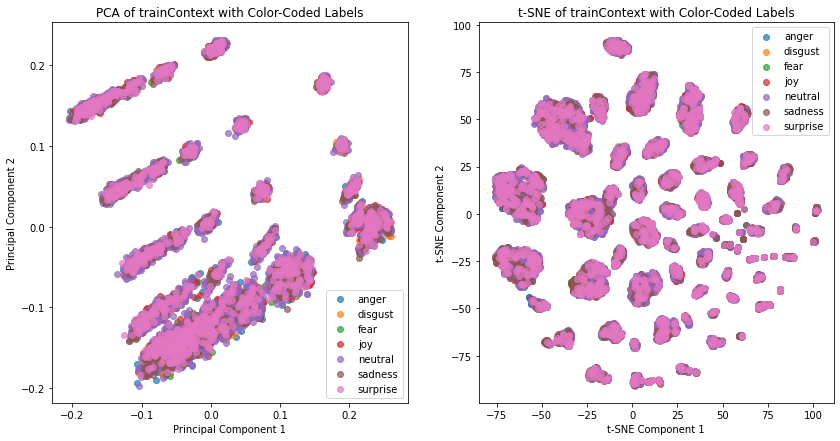

In [49]:
if key:
    # Assuming trainContext, X_train, and labelDecoder are already defined
    num_instance = len(X_train["Emotion"])

    # Calculate the counts for each unique label
    unique_labels, label_counts = np.unique(list(X_train["Emotion"][:num_instance]), return_counts=True)

    # Print the counts for each unique label
    for label, count in zip(unique_labels, label_counts):
        print(f"{labelDecoder[label]}: {count} occurrences")

    # Remove the middle dimension to get [12840, 200]
    trainContext = trainContext.squeeze(1)

    # Convert the tensor to a numpy array for use with sklearn
    trainContext_np = trainContext.detach().numpy()

    # Perform PCA
    pca = PCA(n_components=2)
    trainContext_pca = pca.fit_transform(trainContext_np)

    # Perform t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    trainContext_tsne = tsne.fit_transform(trainContext_np)

    # Plot PCA results with color-coded labels
    plt.figure(figsize=(14, 7))

    plt.subplot(1, 2, 1)
    for label in unique_labels:
        indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
        plt.scatter(trainContext_pca[indices, 0], trainContext_pca[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('PCA of trainContext with Color-Coded Labels')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()

    # Plot t-SNE results with color-coded labels
    plt.subplot(1, 2, 2)
    for label in unique_labels:
        indices = np.where(X_train["Emotion"][:num_instance] == label)[0]
        plt.scatter(trainContext_tsne[indices, 0], trainContext_tsne[indices, 1], label=labelDecoder[label], alpha=0.7)
    plt.title('t-SNE of trainContext with Color-Coded Labels')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend()

    plt.show()

In [50]:
# labels = torch.tensor(X_train["Emotion"][:num_instance])

In [51]:
# label_decoder

In [52]:
# runTSNE = 1
# if runTSNE:
#     from sklearn.manifold import TSNE
#     import matplotlib.pyplot as plt

#     # List of perplexity values to loop over
#     perplexity_values = [50, 100]

#     # Loop over each perplexity value
#     for perplexity in perplexity_values:
#         # Initialize t-SNE with the current perplexity value
#         tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)

#         # Fit and transform the data using t-SNE
#         h_prime_tsne = tsne.fit_transform(tensor_utterances[:num_instance].detach().numpy())

#         # Plot the node embeddings with different colors for each label
#         plt.figure(figsize=(10, 8))
#         for label, emotion in zip(range(len(label_encoder)), label_encoder):
#             indices = (labels == label).nonzero().squeeze()
#             plt.scatter(h_prime_tsne[indices, 0], h_prime_tsne[indices, 1], label=f'{emotion}')
#         plt.title(f'Utterance Embeddings (Train) Visualization (t-SNE) - Perplexity {perplexity}', color="white")
#         plt.xlabel('Dimension 1', color="white")
#         plt.ylabel('Dimension 2', color="white")
#         plt.legend()
#         plt.show()

<h4> Visualize utterance embedding (u') with PCA

In [53]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(tensor_utterances[:num_instance].detach().numpy())

# # Plot the PCA result with color-coded labels
# plt.figure(figsize=(8, 6))
# for label in np.unique(labels):
#     indices = labels == label
#     plt.scatter(pca_result[indices, 0], pca_result[indices, 1], label=f'{label_decoder[label]}', alpha=0.5)
# plt.title('PCA Visualization of Utterance Embeddings (Train) with Color-Coded Labels')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend()
# plt.grid(True)
# plt.show()